# Introduction to Qiskit Runtime and error mitigation
## IEEE Quantum Week '22

Mariana Bernagozzi, IBM Quantum




# Outline
- Setup the environment
- Estimator and Sampler
- Primitives options
- Error mitigation: twirled readout error mititationn
- Comparison: no REM vs. REM


# Set up the environment


## 1. Sign up for an IBM Quantum account

Instructions can be found at the [Qiskit IBM Runtime](https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.4#qiskit-runtime-on-ibm-quantum) repository.

## 2. Clone this repository

We assume that [git](https://git-scm.com/) is installed.  As a first step, clone the repository and enter the clone's directory:

```sh
$ git clone https://github.com/mberna/ieee-qce22-qiskit-runtime-primitives-tutorial.git
$ cd ieee-qce22-qiskit-runtime-primitives-tutorial
```

The remainder of this document will assume you are in the root directory of the repository.

## 3. Set up a virtual Python Environment

Next, we assume that [Python](https://www.python.org/) 3.8 or higher is installed.  It is recommended to use a Python virtual environment that is dedicated to working with this repo.  The steps in the remainder of this document will assume that this environment is activated using either method.

### Option 1: venv (included in Python)

You can create and activate a virtual environment with the following commands:

```sh
$ python3 -m venv venv
$ source venv/bin/activate
```

The first command creates a virtual environment in the `venv` folder of the current directory.  We recommend using this name, as it will be ignored by git (i.e., we have added it to `.gitignore`).

Any time you open a new shell and wish to work with this repo, you will need to activate it using the second line above.  (If you prefer that the virtual environment be activated automatically any time you enter the directory, you may wish to look into using [direnv](https://direnv.net/) or a similar tool.)

### Option 2: conda (recommended only if it is your tool of choice)

The following commands create and activate a conda virtual environment named `qiskit_runtime_env`:

```sh
$ conda create -n qiskit_runtime_env python=3.8
$ conda activate qiskit_runtime_env
```

Any time you open a new shell and wish to work with this repo, you will need to activate it using the second line above.


## 4. Install the packages

All of the packages needed for this tutorial can be installed by running:

```
$ pip install -r requirements.txt
```

## 5. Verify your installation

Run the [`hello_world.py`](docs/hello_world.py) script to verify your installation:

```shell script
$ python3 ./hello_world.py
```

This script will prompt you for your IBM Quantum token, unless you had previously saved it on disk.
Once finished, the script will print `Hello, World!`. It may take a minute or two for the script to complete.

## 6. Using Jupyter Notebooks

Jupyter should already be installed into the virtual environment if you ran the command in the previous step.

Then, start the notebook server.  From the root directory:

```sh
$ jupyter notebook
```

Make sure the notebook server is started from the same Python environment (venv or conda) from which you ran `pip install -r requirements.txt`; otherwise, it may not find this repo in the path.

Once the notebook server starts, it will provide a URL for accessing it through your web browser.  The tutorial notebooks can be found in the [docs directory](docs/tutorials/README.md).


## Getting started with the Estimator

### Overview
- Lets you ***efficiently*** calculate and interpret expectation values of quantum operators
- Takes a list of ***circuits*** (optionally parameters) and ***observables***
- Returns ***expectation values*** and ***variances*** for a given input

<img src="estimator-diagram2.svg" width="600">

In [ ]:
# instantiate runtime service
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")
service = QiskitRuntimeService(channel="ibm_quantum")

In [ ]:
# import required libraries and instantiate runtime service
from qiskit_ibm_runtime import Session, Estimator, Options
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp

# create circuits and observables
psi1 = RealAmplitudes(num_qubits=2, reps=2)
psi2 = RealAmplitudes(num_qubits=2, reps=3)

H1 = SparsePauliOp.from_list([("II", 1), ("IZ", 2), ("XI", 3)])
H2 = SparsePauliOp.from_list([("IZ", 1)])
H3 = SparsePauliOp.from_list([("ZI", 1), ("ZZ", 1)])

In [ ]:
psi1.decompose().draw(output='mpl')

In [ ]:
psi2.decompose().draw(output='mpl')

In [ ]:
import numpy as np

# generate random theta params
np.random.seed(0)
theta1 = np.random.rand(6) * np.pi
theta2 = np.random.rand(8) * np.pi
theta3 = np.random.rand(6) * np.pi
print(theta1)
print(theta2)
print(theta3)


### Start a session

- Introduce concept of session (factory)
- Allows you to define a job as a collection of iterative calls
- It caches the data to avoid retransmission to the Quantum Datacenter


### Create an Estimator instance

- `Estimator` takes in a `session` object that represents the session to use
- Additionally, you can pass an `options` variable to control the execution environment.


In [ ]:
with Session(service=service, backend="ibmq_qasm_simulator") as session:
    estimator = Estimator(session=session)


## Invoke the Estimator primitive

- Invoke the `Estimator` primitive program using the `run()` method
- Returns a `IBMRuntimeJob` instance
- You can use to query for things like job ID and status. The `result()` method of the job will return the result. 

You can invoke the `run()` method multiple times with the different inputs within a session.




### Specify program inputs

The `Estimator.run()` method takes in the following arguments:

- **circuits**: A list of (parameterized) circuits that you want to investigate.
- **observables**: A list of observables to measure the expectation values.
- **parameters**: A list of parameters for the parameterized circuits. It should be omitted if the circuits provided are not parameterized.
- **parameter_values**: an optional list of concrete parameters to be bound.
- **kwargs**: Additional options to overwrite the default values. 

You can find more details in [the Estimator API reference](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.Estimator.html).



### Run the job & print results

Run the job, specifying your previously defined inputs and options.  Use `circuits`, `observables`, and `parameter_values` to use a specific parameter and observable with the specified circuit.

For example, this line `psi1_H23_result = estimator.run(circuits=[psi1, psi1], observables=[H2, H3], parameter_values=[theta1]*2).result()` specifies the following:

- Return the value for using observable `H2` and parameter `theta1` with the circuit `psi1`.
- Return the value for using observable `H3` and parameter `theta1` with the circuit `psi1`.

In [ ]:
from qiskit_ibm_runtime import Options
options = Options(optimization_level=1)
options.execution.shots = 1024

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    estimator = Estimator(session=session, options=options)

    # calculate [ <psi1(theta1)|H1|psi1(theta1)> ]
    psi1_H1 = estimator.run(circuits=[psi1], observables=[H1],
                            parameter_values=[theta1])
    print(psi1_H1.result())

    # You can invoke run() multiple times!
    
    # calculate [ <psi1(theta1)|H2|psi1(theta1)>, <psi1(theta1)|H3|psi1(theta1)> ]
    psi1_H23 = estimator.run(circuits=[psi1, psi1], observables=[H2, H3], 
                             parameter_values=[theta1]*2)
    print(psi1_H23.result())

    # Ex. 1: Calculate [ <psi2(theta2)|H2|psi2(theta2)> ]
    # psi2_H2 = ...


    # Ex. 2 calculate [ <psi1(theta1)|H1|psi1(theta1)>,
    #                   <psi2(theta2)|H2|psi2(theta2)>,
    #                   <psi1(theta3)|H3|psi1(theta3)> ]
    # psi12_H23 = ...

### Estimator options

`options` can be either a dictionary or a `qiskit_ibm_runtime.Options` class instance. Initializing it as an `Options` class allows you to do auto-complete. 

Some of the settings you can specify using `options`:

* **backend**: Optional string name of backend. If not specified a backend will be selected
    automatically (IBM Cloud only).
* **log_level**: logging level to set in the execution environment. The valid
        log levels are: `DEBUG`, `INFO`, `WARNING`, `ERROR`, and `CRITICAL`.
        The default level is `WARNING`.
* **optimization_level**: How much optimization to perform on the circuits. The default is 1.
* **resilience_level**: How much resilience to build against errors. Higher levels generate more accurate results, at the expense of longer processing times.

You can find more details in [the Options API reference](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.Options.html).

With these arguments, you can create a `Estimator` instance with the desired options. Example:

In [ ]:
# Ex. 3: use optimization_level 3
options = Options()
# options... # hint: use autocomplete
with Session(service=service, backend="ibmq_qasm_simulator") as session:
    estimator = Estimator(session=session, options=options)
    theta4 = [0, 1, 1, 2, 3, 5]

    # calculate [ <psi1(theta1)|H1|psi1(theta1)> ]
    psi1_H1 = estimator.run(circuits=[psi1], observables=[H1], parameter_values=[theta4])
    print(psi1_H1.result())    

## Error mitigation settings
Estimator has a `resilience_level` option
- 0: no error mitigation
- 1: applies twirled readout error mitigation 

In [ ]:
# Ex. 4: Apply REM to the following example
# Remeber REM is enabled when resilience level is 1
options = Options()
# options... # hint: use autocomplete

with Session(service=service, backend="ibmq_qasm_simulator",) as session:
    estimator = Estimator(session=session, options=options)
    theta4 = [0, 1, 1, 2, 3, 5]
    psi1_H1 = estimator.run(circuits=[psi1], observables=[H1], parameter_values=[theta4])
    print(psi1_H1.result())

## Getting started with the Sampler

### Overview
Returns a probability distribution corresponding to the measured samples.

<img src="sampler-diagram.svg" width="600">



In [ ]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import Sampler
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    sampler = Sampler(session=session, options=options)
    job = sampler.run(circuits=bell)
    print(job.result())

    # You can invoke run() multiple times.
    job = sampler.run(circuits=bell)
    print(job.result())

## Twirled readout error mitigation for Estimator
- Measurements are subject to hardware imperfections
- Leads to readout errors
- When we set to 1 the level of resilience, we mitigate those errors
- Comes at additional cost:
  - Repeating computations
  - Possibly alter parameters
  - Increase sampling costs
  - Additional classical post-processing
  
Reference: E. van den Berg, Z. Minev, and K. Temme, _Model-free readout-error mitigation for quantum expectation values_ [arXiv:2012.09738](https://arxiv.org/abs/2012.09738)

## M3 (matrix-free measurement mitigation)

### Overview
M3 consists of three steps:

- Select a system and calibrate over the desired set of qubits.

- Run the circuit(s) of interest on the system.

- Apply the readout correction and post-process.

Reference: https://qiskit.org/documentation/partners/mthree/

### Error mitigation trade-offs

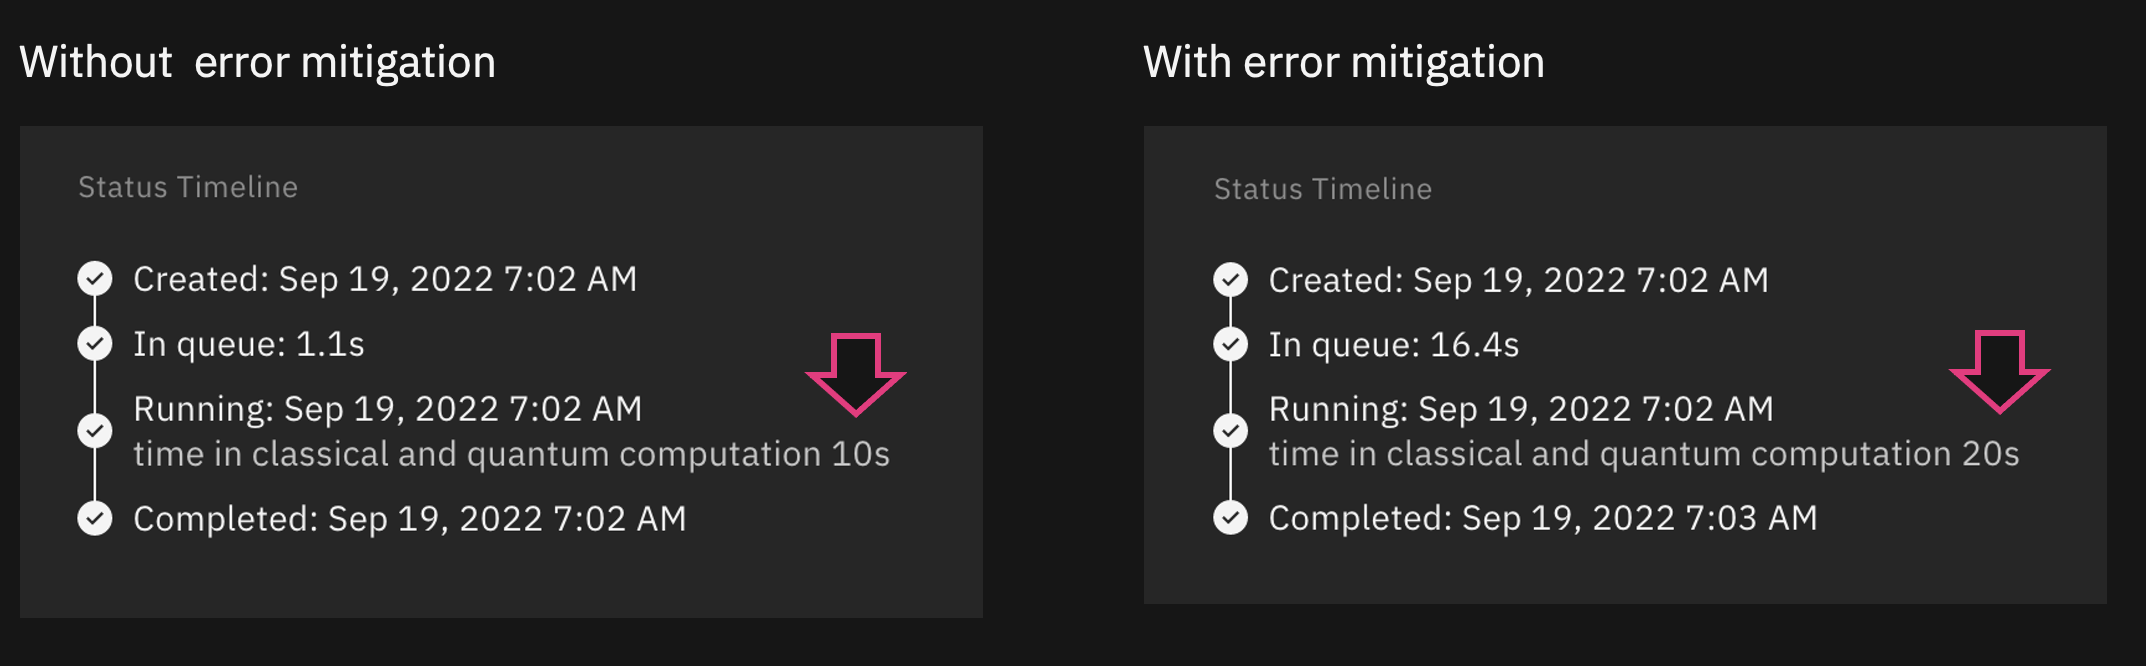

In [ ]:
## REM sampler

from qiskit import QuantumCircuit
from qiskit_ibm_runtime import Sampler, Options, Session
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()

options_rem = Options(resilience_level=1)

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    sampler = Sampler(session=session)
    job = sampler.run(circuits=bell)

    sampler_rem = Sampler(session=session, options=options_rem)
    job_rem = sampler_rem.run(circuits=bell)

    print(f"Quasi_dist without EM {job.result().quasi_dists}")
    print(f"Quasi_dist with EM {job_rem.result().quasi_dists}")